<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

### Image Captioning

In this lab, we are going to combine deep learning workflows to generate descriptions of scenes with AI. The Microsoft Common Object in Context (MSCOCO) data set is comprised of many images and five captions for each image, so we've got an input and a corresponding desired output, the two required ingredients for supervised learning. Our challenge will be identifying the right network and workflow given both visual and language-based data.

With image classification, we learned how to generate a high-level understanding of an image. With the basics of natural language processing, we learned how to use recurrent neural networks (RNNs) to generate text from context. In this lab, we'll learn to add our high-level understanding of images to the context that our RNNs uses to generate language predictions. 

Let's start by importing modules:

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import misc
import sys
sys.path.insert(0, '/dli/data/mdt/models/slim')

slim=tf.contrib.slim
from nets import vgg

from preprocessing import vgg_preprocessing

%matplotlib inline  
!nvidia-smi

Fri Feb 15 09:12:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.26                 Driver Version: 396.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    74W / 149W |      0MiB / 11441MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Pixels to Context

Let's first examine a way to modify an image classification workflow to generate a high-level understanding of an image that retains more information than a simple label.

We will feed the images from MSCOCO through VGG, an award-winning image classification network. Instead of viewing VGG's "softmax" or prediction layer output, we're going to view the layer just before. This is a [feature vector](#fv "An array midway through the neural network that represents some features of the input") called fc7. 

In [2]:
TRAIN_IMAGE_PATH='/dli/data/mdt/mscoco/train2014/'
## Read Training files
with open("/dli/data/mdt/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

image_feature_vectors={}   
tf.reset_default_graph()
    
one_image=ndimage.imread(TRAIN_IMAGE_PATH+data["images"][0]['file_name'])
    #resize for vgg network
resize_img=misc.imresize(one_image,[224,224])
if len(one_image.shape)!= 3: #Check to see if the image is grayscale if True mirror colorband
    resize_img=np.asarray(np.dstack((resize_img, resize_img, resize_img)), dtype=np.uint8)

processed_image = vgg_preprocessing.preprocess_image(resize_img, 224, 224, is_training=False)
processed_images  = tf.expand_dims(processed_image, 0)      
network,endpts= vgg.vgg_16(processed_images, is_training=False)

   
init_fn = slim.assign_from_checkpoint_fn(os.path.join('/dli/data/mdt/mscoco/vgg_16.ckpt'),slim.get_model_variables('vgg_16'))
sess = tf.Session()
init_fn(sess)
NETWORK,ENDPTS=sess.run([network,endpts])
sess.close()
print('fc7 array for a single image')
print(ENDPTS['vgg_16/fc7'][0][0][0])  

INFO:tensorflow:Restoring parameters from /dli/data/mdt/mscoco/vgg_16.ckpt
fc7 array for a single image
[0.81308055 2.55591    0.9547044  ... 1.5095446  0.         0.        ]


It's clear there's a lot of information there. Let's find out what's contained in the "..." by visualizing the vector as a plot instead.

u'COCO_train2014_000000057870.jpg'

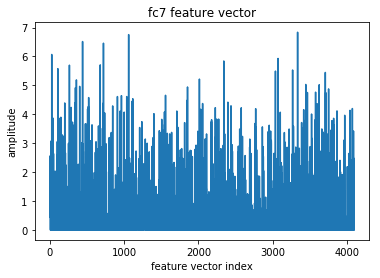

In [3]:
plt.plot(ENDPTS['vgg_16/fc7'][0][0][0])
plt.xlabel('feature vector index')
plt.ylabel('amplitude')
plt.title('fc7 feature vector')
data["images"][0]['file_name']

What you see here are more than 4000 parameters of varying amplitudes. Typically, the next layer of a Convolutional Neural Network (CNN) would simplify that to generate a label, such as "cat" or "dog". However, clearly, there is more to every image than the predominant object it contains.

- What kind of cat?  
- What is it doing?  
- What else is important?  
- Etc.  

You can imagine that the more similar images are to each other, the more similar their feature vectors would be. Therefore, we will use this vector as "context" for our caption generation. 

Before we do that, experiment with the code block below to see the response of different layers in your network. 

How can you look at feature maps from the first convolutional layer? Look here if you need a [hint](#answer1 "The output from the convolutional layer is in the form of height, width, and number of feature maps. FEATUREMAPID can be any value between 0 and the number of feature maps minus 1.").

(224, 224, 64)
input image and feature map from  vgg_16/conv1/conv1_1


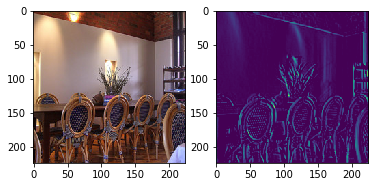

In [7]:
featuremap='vgg_16/conv1/conv1_1'
print(ENDPTS[featuremap][0].shape)
FEATUREMAPID=63
print('input image and feature map from ',featuremap)
plt.subplot(1,2,1)
plt.imshow(resize_img)
plt.subplot(1,2,2)
plt.imshow(ENDPTS[featuremap][0][:,:,FEATUREMAPID])

How can you look at the response of different layers in your network? Experiment above to see if you can. 

## Combining Images and Captions

### Load high-level feature vector from images

For the sake of time, we have run each image in the dataset through VGG and saved the feature vectors to a [numpy](https://www.numpy.org) file. Load them here.

In [8]:
example_load=np.load('/dli/data/mdt/mscoco/train_vgg_16_fc7_2000.npy').tolist()
image_ids=example_load.keys()
print('Number of images in the training set: ', len(example_load.keys()))

Number of images in the training set:  2000


### Aligning captions with images

Next, we are going to correlate the feature maps with their respective captions. Many of the images in the dataset have five captions. Run the code below to view the captions for one image.

MSCOCO captions for a single image


[[u'a restaurant has modern wooden tables and chairs.'],
 [u'a long restaurant table with rattan rounded back chairs.'],
 [u'a long table with a plant on top of it surrounded with wooden chairs '],
 [u'a long table with a flower arrangement in the middle for meetings'],
 [u'a table is adorned with wooden chairs with blue accents.']]

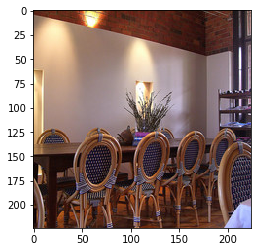

In [9]:
CaptionsForOneImage=[]
for k in range(len(data['annotations'])):
    if data['annotations'][k]['image_id']==data["images"][0]['id']:
        CaptionsForOneImage.append([data['annotations'][k]['caption'].lower()])
plt.imshow(resize_img)
print('MSCOCO captions for a single image')
CaptionsForOneImage

For the sake of time, we've already created a file with feature vectors from 2000 of the MSCOCO images. Next, you will load and align these with captions. Please note this step can take more than 5 minutes to run.  While you wait, take some time to read about and explore the [MSCOCO data set](https://www.mscoco.org).

In [10]:
#Create 3 lists image_id, feature maps, and captions.
image_id_key=[]
feature_maps_to_id=[]
caption_to_id=[]
for observed_image in image_ids:   
    for k in range(len(data['annotations'])):
        if data['annotations'][k]['image_id']==observed_image:
            image_id_key.append([observed_image])
            feature_maps_to_id.append(example_load[observed_image])
            caption_to_id.append(re.sub('[^A-Za-z0-9]+',' ',data['annotations'][k]['caption']).lower()) #remove punctuation 
  
print('number of images ',len(image_ids))
print('number of captions ',len(caption_to_id))

number of images  2000
number of captions  10006


In the cell above we created three lists, one for the image_id, feature map, and caption. To verify that the indices of each list are aligned, display the image id and caption for one image. 

image_id  [[196611], [196611], [196611], [196611], [196611]]
the captions for this image 
[u'a light turned on at a desk with a chair and computer ', u'a living room with the light on next to a computer desk ', u'a living room with a white chair and desk ', u'a computer on a desk next to an empty chair ', u'empty chair in front of a desk with a laptop computer and lamp ']


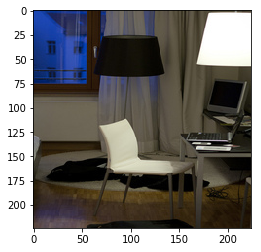

In [11]:
STRING='%012d' % image_id_key[0][0]
exp_image=ndimage.imread(TRAIN_IMAGE_PATH+'COCO_train2014_'+STRING+'.jpg')
plt.imshow(exp_image)
print('image_id ',image_id_key[:5])
print('the captions for this image ')
print(caption_to_id[:5])

Now that we've aligned image ids, feature vectors, and captions, let's organize the captions for training as we did when predicting next words with RNNs.

### Encode our captions and set a dictionary limit

When using one-hot encoding, the vector length of each word is equal to the number of words in the dictionary. Run the cell below to learn about the shape of your data.

In [12]:
num_steps=20
######################################################################
##Create a list of all of the sentences.
DatasetWordList=[]
for dataset_caption in caption_to_id:
        DatasetWordList+=str(dataset_caption).split()
#Determine number of distinct words 
distinctwords=collections.Counter(DatasetWordList)
#Order words 
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
#DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words)#[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#####################  Tokenize Sentence #######################
Tokenized=[]
for full_words in caption_to_id:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        #b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]
        
print("Number of words in this dictionary ", len(words))

Number of words in this dictionary  4644


In [13]:
#Tokenized Sentences
Tokenized[::2000]

[[3, 180, 1030, 4, 17, 3, 334, 8, 3, 156, 9, 166, 2, 0, 0, 0, 0, 0, 0, 0],
 [3, 46, 5, 254, 771, 12, 7, 833, 45, 7, 501, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 [162, 243, 44, 79, 385, 5, 161, 431, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 164, 5, 19, 18, 16, 117, 3, 499, 114, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [79, 116, 6, 97, 1184, 6, 7, 1253, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 56, 168, 65, 45, 602, 184, 8, 3, 2231, 52, 2, 0, 0, 0, 0, 0, 0, 0, 0]]

The next cell contains functions for queuing our data and creating the RNN model. What should the output for each function be? If you need a hint hover [here](#answer2 "The data_queue function batches the data for us, this needs to return tokenized_caption, input_feature_map. The RNN model should return prediction before the softmax is applied and is defined as pred.").

In [15]:
def data_queue(caption_input,feature_vector,batch_size,):


    train_input_queue = tf.train.slice_input_producer(
                    [caption_input, np.asarray(feature_vector)],num_epochs=10000,
                                    shuffle=True) #False before

    ##Set our train data and label input shape for the queue

    TrainingInputs=train_input_queue[0]
    FeatureVectors=train_input_queue[1]
    TrainingInputs.set_shape([num_steps])
    FeatureVectors.set_shape([len(feature_vector[0])]) #fc7 is 4096
    min_after_dequeue=1000000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    tokenized_caption, input_feature_map = tf.train.batch([TrainingInputs, FeatureVectors],
                                                 batch_size=batch_size,
                                                 capacity=capacity,
                                                 num_threads=6)
    return tokenized_caption, input_feature_map
    
    

def rnn_model(Xconcat,input_keep_prob,output_keep_prob,num_layers,num_hidden):
#Create a multilayer RNN
#reuse=False for training but reuse=True for sharing
    layer_cell=[]
    for _ in range(num_layers):
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=input_keep_prob,
                                          output_keep_prob=output_keep_prob)
        layer_cell.append(lstm_cell)

    cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
    outputs, last_states = tf.contrib.rnn.static_rnn(
        cell=cell,
        dtype=tf.float32,
        inputs=tf.unstack(Xconcat))

    output_reshape=tf.reshape(outputs, [batch_size*(num_steps),num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
    pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
    return pred

Now, we'll train our RNN. We'll use the technique outlined in the papers referenced in [1], [2], and [3]: where, at each time step, we'll feed the RNN the current caption AND the feature vector of the image by concatenating each new input with the feature vector. Feel free to examine the papers to dive deeper.

In [16]:
tf.reset_default_graph()
#######################################################################################################
# Parameters
num_hidden=2048
num_steps=num_steps
dict_length=len(words)
batch_size=4
num_layers=2
train_lr=0.00001
#######################################################################################################
TrainingInputs=Tokenized
FeatureVectors=feature_maps_to_id

## Variables ## 
# Learning rate placeholder
lr = tf.placeholder(tf.float32, shape=[])
#tf.get_variable_scope().reuse_variables()

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


tokenized_caption, input_feature_map=data_queue(TrainingInputs,FeatureVectors,batch_size)
mscoco_dict=words

TrainInput=tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32)
#Pad the beginning of our caption. The first step now only has the image feature vector. Drop the last time step 
#to timesteps to 20
TrainInput=tf.concat([tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32),
                      tokenized_caption],1)[:,:-1]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), TrainInput) #[batch,num_steps,dictionary_length][2,6,7]
#ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([input_feature_map+tf.zeros([num_steps,batch_size,4096]), 
                     tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)


#the full caption is the target sentence
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), tokenized_caption),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))

optimizer = tf.train.MomentumOptimizer(lr,0.9)

gvs = optimizer.compute_gradients(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)
capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
train_op=optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
    saver.restore(sess, '/dli/data/mdt/mscoco/rnn_layermodel_iter40000')
    print('Model restored from file')
    
    for i in range(100):
        
        loss,y_pred,target_caption,_=sess.run([cost,pred,tokenized_caption,train_op],feed_dict={lr:train_lr})

        if i% 10==0:
            print("iteration: ",i, "loss: ",loss)
            
    MODEL_NAME='/dli/data/mdt/mscoco/rnn_model_iter'+str(i)
    saver.save(sess, MODEL_NAME) 
    print('saved trained network ',MODEL_NAME)
    print("Done Training")
    coord.request_stop()
    coord.join(threads)
    sess.close() 


INFO:tensorflow:Restoring parameters from /dli/data/mdt/mscoco/rnn_layermodel_iter40000
Model restored from file
iteration:  0 loss:  0.96809363
iteration:  10 loss:  0.9035469
iteration:  20 loss:  0.74450374
iteration:  30 loss:  0.67561066
iteration:  40 loss:  0.86615366
iteration:  50 loss:  0.85354847
iteration:  60 loss:  0.6426744
iteration:  70 loss:  0.49016225
iteration:  80 loss:  0.9202701
iteration:  90 loss:  0.7110841
saved trained network  /dli/data/mdt/mscoco/rnn_model_iter99
Done Training


Try adding some print statements to inspect the size of the input of the to the RNN.  What is the shape of the input to the RNN after the feature vector and caption are merged? Hover [here](#print "print(Xconcat.shape)") for a hint.

We've asked TensorFlow to measure loss as the 'cross-entropy with logits' of the last layer of our network. This loss measurement is what allows our network to learn and helps us compare performance to other solutions, but you may be more interested in whether our current solution *works* as compared to what *we* know about a satisfactory prediction.

We can use the function below to evaluate a single image and its caption from the last batch using the index of the batch. If you need a hint hover [here](#answer3 "if the batch_size is 4, batch_id may be any value between 0 and 3.").

##### Please note that depending on the status of the neural network at the time it was saved, incomplete, incoherent, and sometimes inappropriate captions could be generated.

Caption
['two', 'plates', 'each', 'with', 'a', 'donut', 'water', 'and', 'tea', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted Words
['two', 'each', 'are', 'two', 'silver', 'silver', 'with', 'and', 'glasses', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


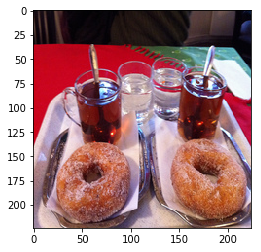

In [17]:
def show_next_predicted_word(batch_id,batch_size,id_of_image,target_caption,predicted_caption,words,PATH):
        Target=[words[ind] for ind in target_caption[batch_id]]
        Prediction_Tokenized=np.argmax(predicted_caption[batch_id::batch_size],1)
        Prediction=[words[ind] for ind in Prediction_Tokenized]
        STRING2='%012d' % id_of_image
        img=ndimage.imread(PATH+STRING2+'.jpg')
        return Target,Prediction,img,STRING2

#You can change the batch id to a number between [0 , batch_size-1]
batch_id=3
image_id_for_predicted_caption=[x for x in range(len(Tokenized)) if target_caption[batch_id].tolist()== Tokenized[x]][0]


t,p,input_img,string_out=show_next_predicted_word(batch_id,batch_size,image_id_key[image_id_for_predicted_caption][0]
                                         ,target_caption,y_pred,words,TRAIN_IMAGE_PATH+'COCO_train2014_')
print('Caption')
print(t)
print('Predicted Words')
print(p)
plt.imshow(input_img)


So far, this is a "next-word" predictor with the addition of the image as context. Can you think of deployment scenarios where this can be helpful? If so, it works pretty well. However, it doesn't yet solve the challenge we set out to tackle:

**Can we generate descriptions of scenes?**

Let's load our saved network and use it to generate a caption from a validation image:

The validation images are stored in /dli/data/mdt/mscoco/val2014. A numpy file of the feature vectors is stored /dli/data/mdt/mscoco/val_vgg_16_fc7_100.npy. Add it using the np.load function below by replacing the ```'##FIXME##'``` with ```'/dli/data/mdt/mscoco/val_vgg_16_fc7_100.npy'```.

In [18]:
##Load and test our test set
val_load=np.load('/dli/data/mdt/mscoco/val_vgg_16_fc7_100.npy').tolist()
val_ids=val_load.keys()

#Create 3 lists image_id, feature maps, and captions.
val_id_key=[]
val_map_to_id=[]
val_caption_to_id=[]
for observed_image in val_ids:   
    val_id_key.append([observed_image])
    val_map_to_id.append(val_load[observed_image])
    
print('number of images ',len(val_ids))
print('number of captions ',len(val_map_to_id))

number of images  100
number of captions  100


The cell below will load **only** a feature vector from one of the images in the validation data set and use it with our pretrained network to generate a caption. Use the VALDATA variable to propagate an image through our RNN and generate a caption. You also need to load the network you just created during training by inserting the file path '/dli/data/mdt/mscoco/rnn_model_iter99' into the ##FIXME## at saver.restore. Look here if you need a [hint](#answer5 "Any of the of the data points in our validation set can be used here. There are 501 captions. Any number between 0 and 100-1 can be used for the VALDATA parameter, such as VALDATA=10.).

##### Please note that depending on the status of the neural network at the time it was saved, incomplete, incoherent, and sometimes inappropriate captions could be generated.

INFO:tensorflow:Restoring parameters from /dli/data/mdt/mscoco/rnn_model_iter99
Model restored from file
predicted sentence:  ['a', 'man', 'with', 'a', 'pair', 'on', 'a', 'city', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


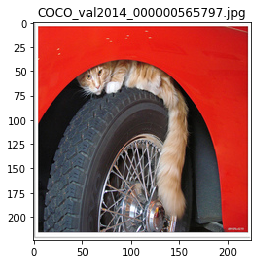

In [21]:
tf.reset_default_graph()
batch_size=1
num_steps=20
print_topn=0 #0for do not display 
printnum0f=3
#Choose a image to caption
VALDATA=5  #ValImage fc7 feature vector

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


StartCaption=np.zeros([batch_size,num_steps],dtype=np.int32).tolist()

CaptionPlaceHolder = tf.placeholder(dtype=tf.int32, shape=(batch_size , num_steps))

ValFeatureMap=val_map_to_id[VALDATA]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), CaptionPlaceHolder) #[batch,num_steps,dictionary_length][2,6,7]
    #ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([ValFeatureMap+tf.zeros([num_steps,batch_size,4096]), 
                            tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)
pred=tf.nn.softmax(pred)
saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
    saver.restore(sess, '/dli/data/mdt/mscoco/rnn_model_iter99')
    print('Model restored from file')
    for i in range(num_steps-1):
        predict_next_word=sess.run([pred],feed_dict={CaptionPlaceHolder:StartCaption})
        INDEX=np.argmax(predict_next_word[0][i])
        StartCaption[0][i+1]=INDEX
        ##Post N most probable next words at each step
        if print_topn !=0:
            print("Top ",str(printnum0f), "predictions for the", str(i+1), "word in the predicted caption" )
            result_args = np.argsort(predict_next_word[0][i])[-printnum0f:][::-1]
            NextWord=[words[x] for x in result_args]
            print(NextWord)
        
    coord.request_stop()
    coord.join(threads)
    sess.close() 

STRING2='%012d' % val_id_key[VALDATA][0]
img=ndimage.imread('/dli/data/mdt/mscoco/val2014/COCO_val2014_'+STRING2+'.jpg')
plt.imshow(img)
plt.title('COCO_val2014_'+STRING2+'.jpg')
PredictedCaption=[words[x] for x in StartCaption[0]]
print("predicted sentence: ",PredictedCaption[1:])

Depending on which image you choose, you'll get a different caliber of result. While there are different ways to improve results: more training, a bigger/more diverse dataset, better data-network fit, etc, we're going to end this lab with an understanding of this *workflow* and move to attack another challenge: how can we create a caption for video?

We'll introduce the difference, but then a lot of the workflow will be identical, so you will attempt to recreate it using this notebook and what you have already learned about Recurrent Neural Networks as a model. Run the cell below to make room in memory, which will give you an expected *Dead Kernel* error. 

In [ ]:
#Free our GPU memory before proceeding to the next part of the lab
import os
os._exit(00)


Then open the next notebook, [Video Captioning Challenge](../../task-assessment/task/VideoCaptioning.ipynb)

<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

## References 

[1] Donahue, J, et al. "Long-term recurrent convolutional networks for visual recognition and description."     Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[2]Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.

[3] TensorFlow Show and Tell:A Neural Image Caption Generator [example] (https://github.com/tensorflow/models/tree/master/im2txt)

[4] Karapthy, A. [NeuralTalk2](https://github.com/karpathy/neuraltalk2)

[5]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.